**Review**

Hello Brian!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
   
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Keep up the good work on the next sprint!

# Introduction

In the below analysis we will be studying the data for 100,000 drilling points for each of three regions for prospective oil wells. Each drilling point has three unknown features which theoretically correspond to the size of the oil reserve each drilling point has. We will train regression models for each region taking these three features as inputs and the oil reserve amount as targets. Because we will base our business' future surveys (and thereby future wells) on the predictions made by the model, our metric for suitable region to drill is profitability of the region based solely on model predictions. We can use a bootstrapping technique to estimate the 95% confidence interval of how well a model selects the best 200 drilling points out of a random 500 points. If a model selects 200 drilling points that are ultimately profitable against the cost of drilling, we will count that as a success.


## Initialize Libraries, Look at Dataframe, Clean the Data

### Libraries

In [1]:
# Statistical libraries
import pandas as pd
from scipy import stats as st
import numpy as np
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Graphing libraries
from matplotlib import pyplot as plt

In [1]:
!zip -r oilygiant.zip /datasets/geo_data_2.csv /datasets/geo_data_1.csv /datasets/geo_data_0.csv

  adding: datasets/geo_data_2.csv (deflated 47%)
  adding: datasets/geo_data_1.csv (deflated 56%)
  adding: datasets/geo_data_0.csv (deflated 47%)


### Dataframe

In [2]:
# Read Dataframe
df_reg1_raw = pd.read_csv('/datasets/geo_data_0.csv')
df_reg2_raw = pd.read_csv('/datasets/geo_data_1.csv')
df_reg3_raw = pd.read_csv('/datasets/geo_data_2.csv')

# Quick look
df_reg1_raw.info()
display(df_reg1_raw.head(3))
df_reg2_raw.info()
display(df_reg2_raw.head(3))
df_reg3_raw.info()
display(df_reg3_raw.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


### Check for Duplicates, Clear Irrelevant Features

The data all looks clean and of the correct type. We will assume based on the above samples that the scales of the f0, f1, and f2 features are equivalent and do not merit re-scaling.

We will quickly check for duplicate rows both within each dataframe and between them before we remove the ids and move on to analysis:

In [3]:
# Check for duplicates, combining all three dataframes
all_df = pd.concat([df_reg1_raw, df_reg2_raw, df_reg3_raw])
print('Duplicate entries in entire dataset :') 
display(all_df[all_df.duplicated()])

Duplicate entries in entire dataset :


,id,f0,f1,f2,product


There appear to be no duplicate rows in the entire dataset combining all three regions.

In [4]:
# We can remove the 'id' feature from each, as it is merely an identifier and should not be used to train the model.
df_reg1 = df_reg1_raw.drop('id', axis=1)
df_reg2 = df_reg2_raw.drop('id', axis=1)
df_reg3 = df_reg3_raw.drop('id', axis=1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and prepared

</div>

## Training a Linear Regression Model for Each Region

### Split Dataframes Into a Training Set and a Validation Set

In [5]:
# Separate dataframes into features and targets and randomize using train_test_split at ratio of 75:25
# Currently do not need test set separate from the validation set as we are not tuning hyperparameters
features_reg1 = df_reg1.drop(['product'], axis=1)
target_reg1 = df_reg1['product']
features_train_reg1, features_valid_reg1, target_train_reg1, target_valid_reg1 = train_test_split(
    features_reg1, target_reg1, test_size=0.25, random_state=12345)

features_reg2 = df_reg2.drop(['product'], axis=1)
target_reg2 = df_reg2['product']
features_train_reg2, features_valid_reg2, target_train_reg2, target_valid_reg2 = train_test_split(
    features_reg2, target_reg2, test_size=0.25, random_state=12345)

features_reg3 = df_reg3.drop(['product'], axis=1)
target_reg3 = df_reg3['product']
features_train_reg3, features_valid_reg3, target_train_reg3, target_valid_reg3 = train_test_split(
    features_reg3, target_reg3, test_size=0.25, random_state=12345)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data for each region was split into train and validation

</div>

### Build Model for Each Region

Below we have no hyperparameters to tune as we are utilizing linear regression, so we do not need to iterate over hyperparameters to minimize RMSE. We can quickly train and store RMSE values for each region's model.

In [6]:
# Linear regression model for each region 
model1 = LinearRegression()
model1.fit(features_train_reg1, target_train_reg1) # train model on training set
predictions_reg1 = model1.predict(features_valid_reg1) # get model predictions on validation set

model2 = LinearRegression()
model2.fit(features_train_reg2, target_train_reg2) # train model on training set
predictions_reg2 = model2.predict(features_valid_reg2) # get model predictions on validation set

model3 = LinearRegression()
model3.fit(features_train_reg3, target_train_reg3) # train model on training set
predictions_reg3 = model3.predict(features_valid_reg3) # get model predictions on validation set

### Calculate Average Oil Volume Predictions and RMSE for Each Region's Model

In [7]:
# RMSE (Root Mean Square Error) for each region's model predictions
rmse_reg1 = mean_squared_error(target_valid_reg1, predictions_reg1)**(1/2)
rmse_reg2 = mean_squared_error(target_valid_reg2, predictions_reg2)**(1/2)
rmse_reg3 = mean_squared_error(target_valid_reg3, predictions_reg3)**(1/2)

# For ease of plotting, combine into dataframe
cols = ['region', 'predict_mean', 'target_mean', 'rmse']
data = [
    [1, predictions_reg1.mean(), target_valid_reg1.mean(), rmse_reg1],
    [2, predictions_reg2.mean(), target_valid_reg2.mean(), rmse_reg2],
    [3, predictions_reg3.mean(), target_valid_reg3.mean(), rmse_reg3]
]
model_stats = pd.DataFrame(data, columns=cols)

display(model_stats)

,region,predict_mean,target_mean,rmse
0,1,92.592568,92.078597,37.579422
1,2,68.728547,68.723136,0.893099
2,3,94.965046,94.884233,40.029709


<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were trained and evaluated correctly

</div>

### Graph Average Oil Volume Predictions and RMSE for each Region

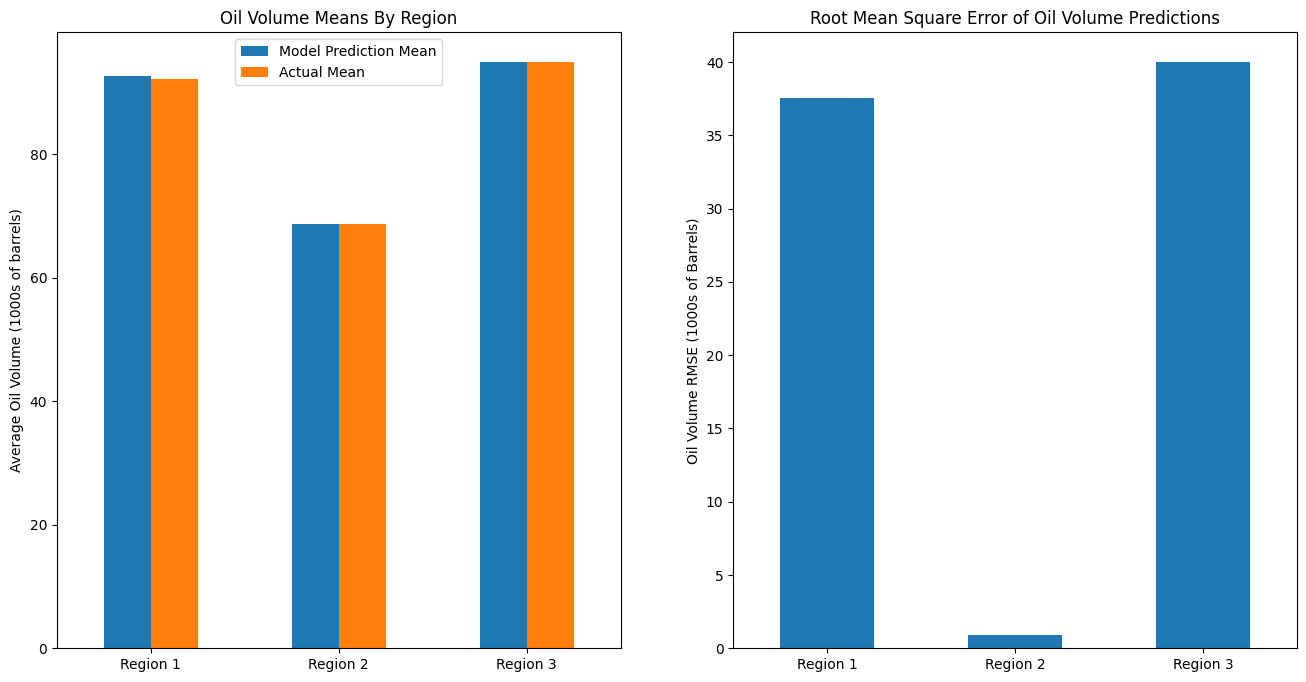

In [8]:
# Create bar plots comparing regional oil volume predictions and actual oil volume in validation set
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].clear()
model_stats[['predict_mean', 'target_mean']].plot(
    kind='bar', 
    ax=axs[0]
)
axs[0].set_ylabel('Average Oil Volume (1000s of barrels)')
axs[0].set_xticklabels(labels=['Region 1', 'Region 2', 'Region 3'])
axs[0].set_title('Oil Volume Means By Region')
axs[0].legend(['Model Prediction Mean', 'Actual Mean'])
axs[0].tick_params(axis='x', rotation=0)

axs[1].clear()
model_stats[['rmse']].plot(
    kind='bar', 
    ax=axs[1]
)
axs[1].set_ylabel('Oil Volume RMSE (1000s of Barrels)')
axs[1].set_xticklabels(labels=['Region 1', 'Region 2', 'Region 3'])
axs[1].set_title('Root Mean Square Error of Oil Volume Predictions')
axs[1].get_legend().remove()
axs[1].tick_params(axis='x', rotation=0)
plt.show()

The preliminary performance of the models is very high when considering the predicted mean of each region's oil reserves. However, there is a worryingly large RMSE in Regions 1 and 3. This may mean that oil volumes for individual drilling points are far less predictabile in these regions despite the regional averages being predictable.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Right!

</div>

## Profit Calculation

We are tasked with determining profitability of drilling in these regions if we were to rely on model predictions for new drilling locations. For our purposes, we are drilling 200 points in a given region, which is estimated to cost 100 million USD. In order to be profitable, the average drilling point should therefore net about 500,000 USD. A unit of reserve (1000 barrels of oil) brings 4,500 USD.

We can represent all of this below:

In [9]:
# List all above items used for profitability calculation in variables
survey_locats = 500
drill_locats = 200
cost = 100000000
unit_price_oil = 4500
profit_well_usd = cost / drill_locats
reserve_size_profit_well = profit_well_usd / unit_price_oil

print("In order to be on average profitable, a drilling point needs an oil reserve with {:.4f} units of oil.".format(reserve_size_profit_well))

In order to be on average profitable, a drilling point needs an oil reserve with 111.1111 units of oil.


The average drilling point should have approximately 111.1111 units of oil, or 111,111 barrels, in reserve. Since the average drilling point across all three regions is about 83 units of oil, all a model has to do is consistently find productive drilling points about 30 units of oil greater than random chance. While regions 1 and 3 have higher average reserves, it is far easier to predict values for region 2 using linear regression given how low the RMSE is for region 2. 

We have to perform some risk analysis to determine if the model can perform well enough to go for the less-predictable but richer-yield regions. It could very well be the case that the model only needs to predict a few drilling points that perform extremely well, and the rest may be below the threshold 111.1111 units of oil. However, the model would need to be able to find those stronger drilling points consistently and often enough to prohibit the risk of loss.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Calculation is correct, cocnlusion makes sense

</div>


## Profit Calculations

### Function for Profit

In [10]:
'''
Inputs:
    'wells': Series, sliced to indicate a subsection of a region's oil reserves, which is the target for the model.
            There must be n rows, which corresponds with the size of the next parameter:
    'predictions': Series with n scalars containing predicted oil reserves the regression model expects for the above wells.
Outputs:
    Returns a scalar reflecting the total profit of selling all oil contained in those 200 wells which the model predicts will
        contain the most oil, which is the gross profit after the cost of drilling 200 wells.
''' 
def survey_profitability(wells, predictions):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = wells[preds_sorted.index][:drill_locats]
    return (unit_price_oil * selected.sum()) - cost

<div class="alert alert-success">
<b>Reviewer's comment</b>

Profit is calculated correctly

</div>

### First Look at Profitability: Let Model Predict Best 200 Wells of Each Region from Validation Set

In [11]:
# Pass Series of regional oil reserves target (validation set) and model predictions (validation set) for each region
predict_reg1 = pd.Series(predictions_reg1)
target_reg1 = target_valid_reg1.reset_index(drop=True)
top200_profit_reg1 = survey_profitability(target_reg1, predict_reg1)

predict_reg2 = pd.Series(predictions_reg2)
target_reg2 = target_valid_reg2.reset_index(drop=True)
top200_profit_reg2 = survey_profitability(target_reg2, predict_reg2)

predict_reg3 = pd.Series(predictions_reg3)
target_reg3 = target_valid_reg3.reset_index(drop=True)
top200_profit_reg3 = survey_profitability(target_reg3, predict_reg3)

print('')
print('Max Gross Profit of Region 1 Based on Model Predictions: {:.2f} USD.'.format(top200_profit_reg1))
print('Max Gross Profit of Region 2 Based on Model Predictions: {:.2f} USD.'.format(top200_profit_reg2))
print('Max Gross Profit of Region 3 Based on Model Predictions: {:.2f} USD.'.format(top200_profit_reg3))
print('')


Max Gross Profit of Region 1 Based on Model Predictions: 33208260.43 USD.
Max Gross Profit of Region 2 Based on Model Predictions: 24150866.97 USD.
Max Gross Profit of Region 3 Based on Model Predictions: 27103499.64 USD.



Because the max profitability of each region is within an order of magnitude, and because it is surprisingly easy to turn a profit in any of the three regions, the deciding factor will be the reliability of the model in accurately predicting a region's oil reserves, and *not* the average reserves of each region. In that respect, region 2 is the current front-runner for investment, as the model has the lowest RMSE and thus should be expected to perform the best when evaluating new prospective drilling points.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

> and because it is surprisingly easy to turn a profit in any of the three regions
    
Not sure what this claim is based on: at this point you only calculated profit from overall top 200 wells in each region (and we have the budget for initial measurements that would allow us to use our models for predictions at 500 randomly selected locations, so the overall top 200 wells are highly unlkely to be among them)

</div>

## Risks and Profitability 

### Find 95% Confidence Interval by Bootstrapping 1000 Hypothetical Surveys on Validation Set

In [14]:
# Create holders for profit values of each hypothetical survey
values_reg1 = []
values_reg2 = []
values_reg3 = []

# Simulate 1000 hypothetical surveys using validation set and run survey_profitability function for each
state = np.random.RandomState(12345)
for i in range(1000):
    target_subsample = target_reg1.sample(n=survey_locats, replace=True, random_state=state)
    predict_subsample = predict_reg1[target_subsample.index]
    values_reg1.append(survey_profitability(target_subsample, predict_subsample))
   
    target_subsample = target_reg2.sample(n=survey_locats, replace=True, random_state=state)
    predict_subsample = predict_reg2[target_subsample.index]
    values_reg2.append(survey_profitability(target_subsample, predict_subsample))
    
    target_subsample = target_reg3.sample(n=survey_locats, replace=True, random_state=state)
    predict_subsample = predict_reg3[target_subsample.index]
    values_reg3.append(survey_profitability(target_subsample, predict_subsample))

values_reg1 = pd.Series(values_reg1)
values_reg2 = pd.Series(values_reg2)
values_reg3 = pd.Series(values_reg3)

# Risk of loss as ratio of negative profit to total values
rol_reg1 = values_reg1[values_reg1 < 0].count()/1000
rol_reg2 = values_reg2[values_reg2 < 0].count()/1000
rol_reg3 = values_reg3[values_reg3 < 0].count()/1000

# 95% Confidence Interval represents the middle region of data where 2.5% of the data is above and 2.5% of the data is below
cols = ['region', 'mean_profit', 'lower_quantile_profit', 'upper_quantile_profit', 'risk_of_loss', 'risk_of_loss_perc']
data = [
    [1, values_reg1.mean(), values_reg1.quantile(0.025), values_reg1.quantile(0.975), rol_reg1, rol_reg1*100], 
    [2, values_reg2.mean(), values_reg2.quantile(0.025), values_reg2.quantile(0.975), rol_reg2, rol_reg2*100],
    [3, values_reg3.mean(), values_reg3.quantile(0.025), values_reg3.quantile(0.975), rol_reg3, rol_reg3*100]
]

boot_survey_results = pd.DataFrame(data, columns=cols)
display(boot_survey_results)

,region,mean_profit,lower_quantile_profit,upper_quantile_profit,risk_of_loss,risk_of_loss_perc
0,1,4.147363e+06,-1.235281e+06,9.685629e+06,0.070,7.0
1,2,5.131722e+06,8.532975e+05,9.401063e+06,0.009,0.9
2,3,4.101984e+06,-1.404237e+06,9.677162e+06,0.085,8.5


<div class="alert alert-success">
<b>Reviewer's comment</b>

Bootstrapping is done correctly, all needed statistics are calculated.

</div>

### Ideal Region for Investment

Only one region has a risk of loss below 2.5%, and that is region 2. In region 2, 99.1% of 500 hypothetical surveyed drill site groupings could be filtered down to 200 profitable oil rigs. In the other two regions, there are enough profitable oil reserve sites -- more, even, than in region 2 -- but the model cannot represent the surface data in such a way as to consistently predict their reserves with minimal error. The business should invest in region 2.

# Conclusion

The above linear regression models could be trained to significantly increase the business' ability to decide which of three regions to drill for oil. While regions 1 and 3 held marginally more oil reserves on average, region 2 was far more predictable and the error rate of the model was an order of magnitude lower. This resulted in region 2 being the best candidate for drilling, with a risk of loss of ony 0.9%.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Region choice is correct and justified. Well done!

</div>